# Tutorial: Using `fastai.data` low-level APIs

> Using `DataSource`, `Pipeline`, `TfmdList`, and `Transform`

In [ ]:
from fastai2.data.all import *
from fastai2.vision.core import *
from fastai2.vision.data import *

## Overview

In the second half of this page we'll look at complete examples of loading and using datasets using the `fastai.data` low-level APIs. But first, let's look at simple examples of the following applied to a single filename:

- `Transform`
- `Pipeline` to composes transforms

(We won't look at `TfmdList`, `DataSource` in this initial overview since they require a full dataset. Have a look at the second half of the page for examples of those.)

### Transform

In [ ]:
source = untar_data(URLs.MNIST_TINY)/'train'
items = get_image_files(source)
fn = items[0]; fn

PosixPath('/home/quantran/.fastai/data/mnist_tiny/train/7/9286.png')

We'll look at each `Transform` needed in turn. Here's how we can open an image file:

In [ ]:
type(items),type(items[0])

(fastcore.foundation.L, pathlib.PosixPath)

In [ ]:
img = PILImage.create(fn) 

img

In [ ]:
type(img), img.shape # fastai specific PIL image obj

(fastai2.vision.core.PILImage, (28, 28))

Quick note on RandomSplitter

In [ ]:
# RandomSplitter is just a function returning another function.
# normally function name should not be capitalized, 
# but this func is not your regular func b/c it returns another func so
RandomSplitter(valid_pct=0.1)(list(range(10))) # random idx of train/test set

((#9) [1,8,3,2,9,4,5,6,0], (#1) [7])

In [ ]:
??RandomSplitter

In [ ]:
print(RandomSplitter)
print(RandomSplitter())

<function RandomSplitter at 0x7f39b8cc1290>
<function RandomSplitter.<locals>._inner at 0x7f39b8b849e0>


Then create a `c*h*w` tensor:

In [ ]:
tconv = ToTensor()
img = tconv(img)
type(img), img.shape # not pytorch tensor, but fastai own TensorImage obj
# This transform.TensorImage type is different from the previous one (fastai2.vision.core.PILImage)

(fastai2.torch_core.TensorImage, torch.Size([3, 28, 28]))

In [ ]:
print(type(ToTensor))
print(type(ToTensor()))

<class 'fastcore.transform._TfmMeta'>
<class 'fastai2.data.transforms.ToTensor'>


Now that's done, we can create our labels. First extracting the text label:

In [ ]:
fn

PosixPath('/home/quantran/.fastai/data/mnist_tiny/train/7/9286.png')

In [ ]:
lbl = parent_label(fn); lbl

'7'

And then converting to an int for modeling:

In [ ]:
tcat = Categorize(vocab=['3','7'])
lbl = tcat(lbl); lbl
# 1 because '7' is at vocab[1]

tensor(1)

`Categorize` has a `decode` to reverse transformation back to the raw label, for display purposes. Reversing the `Categorize` transform result in a class name we can display:

In [ ]:
lbld = tcat.decode(lbl)
lbld

'7'

### Pipeline

We can compose our image steps using `Pipeline`:

In [ ]:
print(fn)
tconv = ToTensor()
pipe = Pipeline([PILImage.create,tconv])
img = pipe(fn) #PILImage.create need a path input, in this case: fn
type(img),img.shape

/home/quantran/.fastai/data/mnist_tiny/train/7/9286.png


(fastai2.torch_core.TensorImage, torch.Size([3, 28, 28]))

A `Pipeline` can decode and show an item.

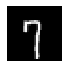

In [ ]:
pipe.show(img, figsize=(1,1), cmap='Greys');

## How 'show' knows where to stop (in order to show)?

Note: The show method works behind the scenes with types. Transforms will make sure the type of an element they receive is preserved. 

pipe.show():

**Here `PILImage.create` returns a `PILImage`, which knows how to show itself.**


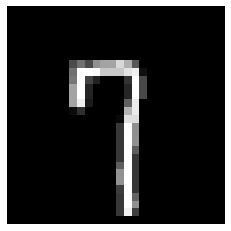

In [ ]:
PILImage.create(fn).show() 

**`tconv` converts it to a `TensorImage`, which also knows how to show itself.**

In [ ]:
type(img)

fastai2.torch_core.TensorImage

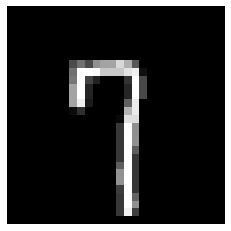

In [ ]:
img.show()

Those types are also used to enable **different behaviors depending on the input received** (for instance you don't do data augmentation the same way on an image vs a segmentation mask vs a bounding box).

## Loading the Pets dataset using only `Transform`

Let's see how to use `fastai.data` to process the Pets dataset. We use *source* to refer to the underlying source of our data (e.g. a directory on disk, a database connection, a network connection, etc).

In [ ]:
source = untar_data(URLs.PETS)/"images"

First we grab the items and split indices:

In [ ]:
items = get_image_files(source)
split_idx = RandomSplitter()(items)

In [ ]:
type(items)
# L is similar to ListContainer, but more advanced

fastcore.foundation.L

In [ ]:
a = L(1,2,3,4)
print(a)
print('-'*5)
print(a[:2])
print(a[0,3])
print(a[[0,3]]) #same
print(a[True,True,True,False]) #mask
print(a+5) #append
print(5+a) # front append

(#4) [1,2,3,4]
-----
(#2) [1,2]
(#2) [1,4]
(#2) [1,4]
(#3) [1,2,3]
(#5) [1,2,3,4,5]
(#5) [5,1,2,3,4]


In [ ]:
# new way to init (in this case, accept a iterator)
L(i*2 for i in range(5))

(#5) [0,2,4,6,8]

In [ ]:
# map a func to all values in list
a = L(1,2,3,4)
a.map(operator.neg)

(#4) [-1,-2,-3,-4]

We'll use this function to create consistently sized pytorch tensors from image files:

In [ ]:
def resized_image(fn:Path, sz=128):
    x = Image.open(fn).convert('RGB').resize((sz,sz))
    # Convert image to pytorch tensor for modeling
    return tensor(array(x)).permute(2,0,1).float()/255.

Before we can create a `Transform`, we need a type that knows how to show itself. Here we define a `TitledImage`:

In [ ]:
items[0]

PosixPath('/home/quantran/.fastai/data/oxford-iiit-pet/images/chihuahua_57.jpg')

In [ ]:
img = resized_image(items[0])

type(img),img.shape

(torch.Tensor, torch.Size([3, 128, 128]))

In [ ]:
img.show() # Note that resized_image does not have a show function (help to explain OpenAndResize andpipeline.show() procedure below)

AttributeError: 'Tensor' object has no attribute 'show'

In [ ]:
class TitledImage(Tuple):
    def show(self, ctx=None, **kwargs): 
        show_titled_image(self, ctx=ctx, **kwargs)

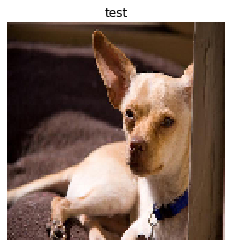

In [ ]:
TitledImage(img,'test').show()

### Try 1: State outside class

In [ ]:
class PetTfm(Transform):
    # as we want to create "domain-specific semantics" to this img, we will store:
    # 1. vocab list (labels), 2. label_dict o2i, 3. labeller (regex labels out of a path)
    # this class will:
    # - spit out (torch tensor, numericalized class) ready for training
    # - can decode back to (torch.tensor, raw class)
    def __init__(self, vocab, o2i, lblr): 
        self.vocab,self.o2i,self.lblr = vocab,o2i,lblr
    def encodes(self, o): 
        # input: posix path of 1 single img 
        # output: tuple of (pytorch tensor scaled, label)
        return resized_image(o), self.o2i[self.lblr(o)]
    def decodes(self, x): 
        # input: output of encodes (x is a tuple)
        # output: TitledImage (basically a fancy tuple with a show function)
        # (see def of TitledImage above)
        return TitledImage(x[0],self.vocab[x[1]])

In [ ]:
split_idx[0]

(#5912) [3515,1264,6402,7375,2829,4301,1269,3089,4393,4236...]

In [ ]:
# create those 'domain-specifc semantics' for Pet img class
labeller = RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')
vals = list(map(labeller, items[split_idx[0]]))
vocab,o2i = uniqueify(vals, sort=True, bidir=True)
pets = PetTfm(vocab,o2i,labeller)

In [ ]:
print(vals[:5])
print(vocab[:5])

['samoyed', 'Birman', 'yorkshire_terrier', 'german_shorthaired', 'keeshond']
(#5) [Abyssinian,Bengal,Birman,Bombay,British_Shorthair]


In [ ]:
o2i

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [ ]:
print(type(pets))
print(pets) 

<class '__main__.PetTfm'>
PetTfm: True (object,object) -> encodes (object,object) -> decodes


In [ ]:
items[0]

PosixPath('/home/quantran/.fastai/data/oxford-iiit-pet/images/chihuahua_57.jpg')

In [ ]:
x,y = pets(items[0]) #PetTfm will call 'encode' with this type of call
x.shape,y

(torch.Size([3, 128, 128]), 17)

In [ ]:
type(x)

torch.Tensor

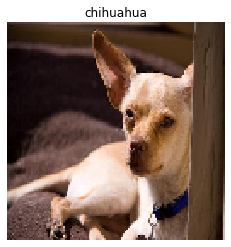

In [ ]:
dec = pets.decode((x,y))
dec.show()

In [ ]:
type(dec)

__main__.TitledImage

In [ ]:
dec[0].shape,dec[1]
# Another reminder that TitledImage is just a 'fancy' tuple (with a show func to draw image)
# fastai treat Tuple class as tuple

(torch.Size([3, 128, 128]), 'chihuahua')

In [ ]:
type(dec[0])

torch.Tensor

### Try 2: State inside class

We can now create a `Transform` that converts from an index to our `x` and `y` for modeling.

In [ ]:
class PetTfm(Transform):
    def __init__(self, items, train_idx):
        self.items,self.train_idx = items,train_idx
        self.labeller = RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')
        vals = map(self.labeller, items[train_idx])
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, i):
        o = self.items[i]
        return resized_image(o), self.o2i[self.labeller(o)]
    
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

Note that `decodes` is intended to operate on the return value of `encodes`. In the case above, `decodes` takes in a tuple consisting of a Tensor representing the image and an integer being the class idx and returns an instance of `TitledImage`.

**Note: It's important to give the type that can show itself to fully decoded elements because when in a `Pipeline`, we stop decoding as soon as we can find a `show` method.**

In [ ]:
pets = PetTfm(items, split_idx[0])

In [ ]:
x,y = pets(0)
x.shape,y

(torch.Size([3, 128, 128]), 17)

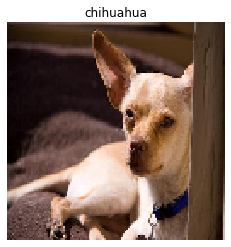

In [ ]:
dec = pets.decode((x,y))
dec.show()

In [ ]:
type(dec)

__main__.TitledImage

## Using `Pipeline` and `Transform subclass` to create Siamese model dataset

A *Siamese* model needs a dataset with two images as input, and a boolean output that is `True` if the two images are the "same" (e.g. are pictures of the same breed of pet). Custom structures like this are often easiest to create using your own `Pipeline`, which makes no assumptions about the structure of your input or output data.

We'll be creating a dataset that returns two images and a boolean. So let's first define a showable type for a tuple with those things:

In [ ]:
class SiameseImage(Tuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self
        return show_image(torch.cat([img1,img2], dim=2), 
                          title=same_breed, ctx=ctx)

In [ ]:
img = resized_image(items[0])
type(img),img.shape

(torch.Tensor, torch.Size([3, 128, 128]))

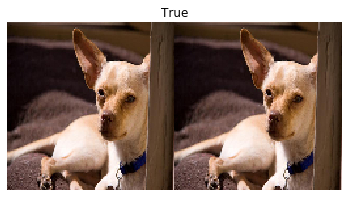

In [ ]:
SiameseImage(img,img,True).show();

We create a `SiamesePair` transform that creates the tuple we'll need for a `SiameseImage`.

In [ ]:
class SiamesePair(Transform):
    def __init__(self,items,labels):
        self.items,self.labels,self.assoc = items,labels,self
        # explanation for these codes below
        sortlbl = sorted(enumerate(labels), key=itemgetter(1))
        # dict of (each unique label) -- (list of indices with that label)
        self.clsmap = {k:L(v).itemgot(0) for k,v in itertools.groupby(sortlbl, key=itemgetter(1))}
        self.idxs = range_of(self.items) # a list [0,1,...,len(items)-1]
        
    def encodes(self,i):
        """
        i: index of image in dataset
        Output is a tuple of 3: `i`th <image posix path>, a random <image path> from same OR different class, y: True if same class
        """
        othercls = self.clsmap[self.labels[i]] if random.random()>0.5 else self.idxs #50/50 chance to pick either: 
        # - list of idxs with same labels[i]
        # - list of sorted numbers from 0 to len(items)-1
        otherit = random.choice(othercls) #then pick a random idx from the list
        
        # return (path of img with idx i, random <image path> from same OR different class, y:True if same class)
        return SiameseImage(self.items[i], self.items[otherit], self.labels[otherit]==self.labels[i])
        # SiameseImage here is Tuple-based, so fastai knows to treat this at a tuple
        
        # Note:
        # return (self.items[i], self.items[otherit], self.labels[otherit]==self.labels[i])      
        # you can even return a raw tuples like above, and OpenAndResize from pipeline can still know which one is the 'image' to perform transformation
        # thanks to Transform class
        

In [ ]:
items.map(labeller)[:5]

(#5) [chihuahua,shiba_inu,Abyssinian,British_Shorthair,german_shorthaired]

In [ ]:
list(enumerate(items.map(labeller)))[:5]

[(0, 'chihuahua'),
 (1, 'shiba_inu'),
 (2, 'Abyssinian'),
 (3, 'British_Shorthair'),
 (4, 'german_shorthaired')]

In [ ]:
# Note: sort a list of tuple by key
temp_sortlbl = sorted(enumerate(items.map(labeller)), key=itemgetter(1))
print(temp_sortlbl[:5])

[(2, 'Abyssinian'), (120, 'Abyssinian'), (132, 'Abyssinian'), (137, 'Abyssinian'), (167, 'Abyssinian')]


In [ ]:
# groupby a list of tuple by key (after sort)
temp_clsmap = {k:L(v).itemgot(0) for k,v in itertools.groupby(temp_sortlbl, key=itemgetter(1))}

In [ ]:
temp_clsmap

{'Abyssinian': (#200) [2,120,132,137,167,180,196,217,223,335...],
 'Bengal': (#200) [56,107,131,148,199,220,263,347,372,392...],
 'Birman': (#200) [27,55,77,93,96,135,143,151,169,197...],
 'Bombay': (#200) [16,24,35,172,331,355,423,493,557,602...],
 'British_Shorthair': (#200) [3,20,25,230,233,251,264,346,349,374...],
 'Egyptian_Mau': (#200) [38,65,68,121,149,190,229,250,275,279...],
 'Maine_Coon': (#200) [19,58,63,109,111,157,201,222,244,282...],
 'Persian': (#200) [34,47,72,89,133,161,166,205,272,297...],
 'Ragdoll': (#200) [26,29,69,76,88,155,160,178,232,252...],
 'Russian_Blue': (#200) [53,158,182,194,241,245,314,322,324,419...],
 'Siamese': (#200) [79,80,265,267,268,289,291,388,485,560...],
 'Sphynx': (#200) [45,138,173,254,478,532,538,610,664,714...],
 'american_bulldog': (#200) [42,50,213,228,342,351,360,407,408,418...],
 'american_pit_bull_terrier': (#200) [8,31,59,113,192,210,236,255,271,293...],
 'basset_hound': (#200) [14,18,154,235,305,312,497,542,558,597...],
 'beagle': (#

Then we want to open and resize the image filenames but not the boolean. This kind of filtering is done with type annotations. We indicated with the return type annotation of `SiamesePair.encodes` the types of our objects and we can then create a new transform that opens and resizes `Path` objects but leaves other types untouched. 

Then the `Pipeline` will compose our two transforms, and create the `SiameseImage`.

Class TupleTransform
```
class TupleTransform(Transform):
    "`Transform` that always treats `as_item` as `False`"
    as_item_force=False
```

In [ ]:
OpenAndResize = TupleTransform(resized_image)
labeller = RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')
sp = SiamesePair(items, items.map(labeller)) # using L.map here

In [ ]:
pipe = Pipeline([sp, OpenAndResize], as_item=True) # as_item: force obj that passes through each transformation as a single obj (a Tuple obj in this case), not as a tuple of multiple objs

x,y,z = t = pipe(0) # in pipeline, sp needs an idx (in this case: 0) as input
# Also, output of sp is 1 SiameseImage obj (TupleBase) of 3 things (img1_path,img2_path,label)
# but OpenAndResize knows to only process first 2 things, thanks to Type Annotation (from resized_imageL: def resized_image(fn:Path, sz=128) )

#Output of OpenAndResize is still a TupleBase SiameseImage
x.shape,y.shape,z

(torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), False)

In [ ]:
type(x),type(y)

(torch.Tensor, torch.Tensor)

In [ ]:
x.show()

AttributeError: 'Tensor' object has no attribute 'show'

In [ ]:
type(t)

__main__.SiameseImage

### Note: Explaining TupleBase subclass (SiameseImage) and how TupleTransform (OpenAndResize) know which obj of the tuple to work on

```
def resized_image(fn:Path, sz=128):
    x = Image.open(fn).convert('RGB').resize((sz,sz))
    # Convert image to tensor for modeling
    return tensor(array(x)).permute(2,0,1).float()/255.
```

Remember resized_image strictly requires fn to be a path thanks to TypeAnnotation?

Basically OpenAndResize class in the pipeline (or specifically, resized_image function) will loop through each value in SiameseImage (which is TupleBase) and resized_image only work on 'path' obj, leaving the label out.


**Pros**: in the TupleTransform, you can have multiple **encodes transform function for different type using type annotation**: => customize different transformation for (different) objects in tuples => convenient!

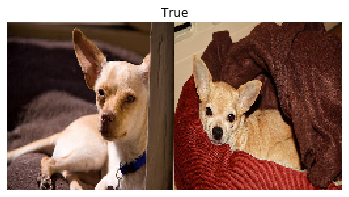

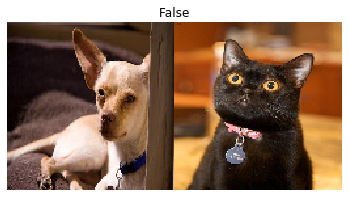

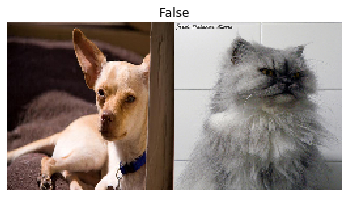

In [ ]:
for _ in range(3): pipe.show(pipe(0)) #show here is from show_img of SiameseImage
    
#Note: the pipe.show uses the 'show' function in SiameseImage, which is spit out by 'encode' in SiamesePair (sp)
#Basically pipe.show will try to decode first (from OpenAndResize -> SiamesePair , and stop where there is a show function 
# (show() in sp, since there is no 'show' in OpenAndResize)

## Using `DataSource` and `TfmdDL`

DataSource applies a list of list of transforms (or list of Pipelines) lazily to items of a collection, creating one output per list of transforms/Pipeline. This makes it easier for us to separate out steps of a process, so that we can re-use them and modify the process more easily. For instance, we could add data augmentation, data normalization, etc. Here we separate out the steps of the basic pets process.



**(there can be multiple validation sets).**

In [ ]:
class ImageResizer(Transform):
    order=10
    "Resize image to `size` using `resample"
    def __init__(self, size, resample=Image.BILINEAR):
        if not is_listy(size): size=(size,size)
        self.size,self.resample = (size[1],size[0]),resample
    
    #like I said above, multiple encodes in 1 transform
    def encodes(self, o:PILImage): return o.resize(size=self.size, resample=self.resample)
    def encodes(self, o:PILMask):  return o.resize(size=self.size, resample=Image.NEAREST)

In [ ]:
labeller = RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')

In [ ]:
tfms = [[PILImage.create, ImageResizer(128), ToTensor(), IntToFloatTensor()],
        [labeller, Categorize()]]
dsrc = DataSource(items, tfms)

In [ ]:
t = dsrc[0]
type(t[0]),type(t[1])

(fastai2.torch_core.TensorImage, fastai2.torch_core.TensorCategory)

In [ ]:
t[0].shape, t[0]

(torch.Size([3, 128, 128]),
 tensor([[[0.2353, 0.2510, 0.2627,  ..., 0.2118, 0.2039, 0.1882],
          [0.1804, 0.1804, 0.1804,  ..., 0.2118, 0.2039, 0.1843],
          [0.1569, 0.1569, 0.1412,  ..., 0.2118, 0.2078, 0.1922],
          ...,
          [0.2784, 0.2431, 0.2941,  ..., 0.0941, 0.2549, 0.6667],
          [0.2431, 0.2157, 0.2824,  ..., 0.1059, 0.2667, 0.6863],
          [0.2510, 0.2941, 0.2588,  ..., 0.1137, 0.2706, 0.6902]],
 
         [[0.1647, 0.1804, 0.1922,  ..., 0.1490, 0.1412, 0.1255],
          [0.1137, 0.1176, 0.1176,  ..., 0.1490, 0.1412, 0.1216],
          [0.0980, 0.0980, 0.0902,  ..., 0.1490, 0.1451, 0.1294],
          ...,
          [0.1843, 0.1490, 0.2000,  ..., 0.0314, 0.1608, 0.5765],
          [0.1490, 0.1216, 0.1882,  ..., 0.0431, 0.1725, 0.5922],
          [0.1569, 0.2000, 0.1647,  ..., 0.0510, 0.1765, 0.5961]],
 
         [[0.1255, 0.1412, 0.1529,  ..., 0.0980, 0.0902, 0.0745],
          [0.0706, 0.0784, 0.0863,  ..., 0.0980, 0.0902, 0.0706],
          [0

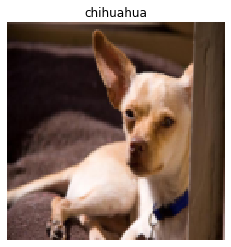

In [ ]:
dsrc.show(t) # DataSource has a show function that combine img and **decoded** y

(<matplotlib.axes._subplots.AxesSubplot at 0x7f398f234810>, tensor(17))

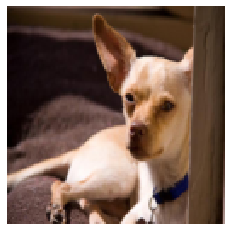

In [ ]:
t[0].show(),t[1]

In [ ]:
x,y = dsrc.decode(t)
x.shape,y

(torch.Size([3, 128, 128]), 'chihuahua')

In [ ]:
type(x),x[0]

(fastai2.torch_core.TensorImage,
 tensor([[0.2353, 0.2510, 0.2627,  ..., 0.2118, 0.2039, 0.1882],
         [0.1804, 0.1804, 0.1804,  ..., 0.2118, 0.2039, 0.1843],
         [0.1569, 0.1569, 0.1412,  ..., 0.2118, 0.2078, 0.1922],
         ...,
         [0.2784, 0.2431, 0.2941,  ..., 0.0941, 0.2549, 0.6667],
         [0.2431, 0.2157, 0.2824,  ..., 0.1059, 0.2667, 0.6863],
         [0.2510, 0.2941, 0.2588,  ..., 0.1137, 0.2706, 0.6902]]))

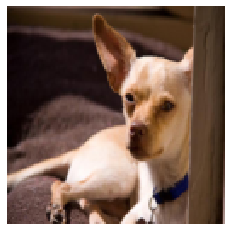

In [ ]:
x.show()

In [ ]:
test_eq(t[0],x) # Note: even though img's path went through a whole 4 tfms in pipeline, 
# decoding (from IntToFloatTensor product) does not go back (or do anything at all), since output of IntToFloatTensor has 'show' function
# Note: remember that decode will stop when there is a 'show' function

### TfmdDL

The types being properly propagated and dispatched, we can do the same thing with ImageResizer, ImageToByteTensor, IntToFloatTensor being passed as tranforms over the tuple. This is done in TfmdDL by passing them to after_item. They won't do anything to the category but will only be applied to the inputs.

In [ ]:
tfms = [[PILImage.create], [labeller, Categorize()]]
dsrc = DataSource(items, tfms)
tdl = TfmdDL(dsrc, bs=1, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor()])

In [ ]:
t = tdl.one_batch()

In [ ]:
type(t),type(t[0]),type(t[1])

(tuple, fastai2.torch_core.TensorImage, fastai2.torch_core.TensorCategory)

In [ ]:
x,y = tdl.decode_batch(t)[0]
x.shape,y

(torch.Size([3, 128, 128]), 'chihuahua')

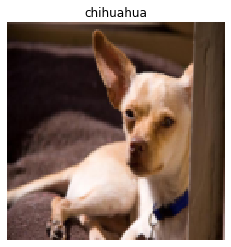

In [ ]:
dsrc.show((x,y));

## Adding splits

In [ ]:
items = get_image_files(source)
split_idx = RandomSplitter()(items)

In [ ]:
type(split_idx)

tuple

In [ ]:
len(split_idx[0]),len(split_idx[1]) # train + val indices

(5912, 1478)

In [ ]:
pets = DataSource(items, tfms, splits=split_idx)

In [ ]:
type(pets)

fastai2.data.core.DataSource

In [ ]:
len(pets)

7390

In [ ]:
tfms

[[<bound method PILBase.create of <class 'fastai2.vision.core.PILImage'>>,
  ImageResizer: True (PILMask,object) -> encodes
  (PILImage,object) -> encodes ,
  ToTensor: True (PILMask,object) -> encodes
  (PILBase,object) -> encodes ,
  IntToFloatTensor: True (TensorMask,object) -> encodes
  (TensorImage,object) -> encodes (TensorImage,object) -> decodes],
  Categorize: True (object,object) -> encodes (object,object) -> decodes]]

In [ ]:
temp = pets[0] # this tfms only have PILImage.create, so the type is PILImage
type(temp[0]),type(temp[1])

(fastai2.torch_core.TensorImage, fastai2.torch_core.TensorCategory)

In [ ]:
temp[0].shape # raw PILImage, no 128 resize yet

torch.Size([3, 128, 128])

In [ ]:
temp[1]

tensor(17)

To access an element we need to specify the subset (either with `train`/`valid` or with `subset(i)`): 

subset(0) is train set, subset(1) is val set (possible to add subset(2), (3)...)

In [ ]:
x,y = pets.subset(1)[0] # first img (idx 0) in val set ( subset(1) ), according to split_idx
x.shape,y

(torch.Size([3, 128, 128]), tensor(11))

In [ ]:
type(x)

fastai2.torch_core.TensorImage

...or equivalently:

In [ ]:
x2,y2 = pets.valid[0]
test_eq(x.shape,x2.shape)
test_eq(x,x2)
test_eq(y,y2)

can also use split_idx

In [ ]:
x3,y3 = pets[split_idx[1][0]]
test_eq(x.shape,x3.shape)
test_eq(y,y3)

We can decode an element for display purposes, either passing a tuple to `decode` or by passing an index to `decode_at`.

In [ ]:
xy = pets.valid.decode((x,y))
len(xy)

2

In [ ]:
xy[1]

'Sphynx'

In [ ]:
type(xy[0])

fastai2.torch_core.TensorImage

In [ ]:
xy2 = decode_at(pets.valid, 0)
test_eq(type(xy2[1]), Category)
test_eq(xy2, xy)

We're now ready to show our items.

In [ ]:
x,y = pets.subset(1)[0]
x.shape,y

(torch.Size([3, 128, 128]), tensor(11))

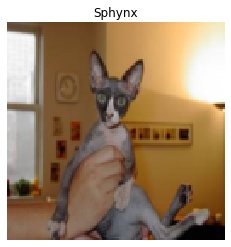

In [ ]:
pets.show((x,y));

In [ ]:
type(pets.valid),type(pets.train)

(fastai2.data.core.DataSource, fastai2.data.core.DataSource)

## DataLoader on GPU

We can use this to feed a `DataLoader` and view a batch. It's faster to convert to float on GPU, so we'll do it as a DataLoader transform, after CUDA in `after_batch`.

Previously 
```
tfms = [[PILImage.create], [labeller, Categorize()]]
dsrc = DataSource(items, tfms)
tdl = TfmdDL(dsrc, bs=1, after_item=[ImageResizer(128), ToTensor(), ByteToFloatTensor()])
```

In [ ]:
tfms = [[PILImage.create], [labeller, Categorize()]]
pets = DataSource(items, tfms, splits=split_idx)

In [ ]:
type(pets.train)
# pets.train is basically tds in the code snippet above (same TfmdDS)

fastai2.data.core.DataSource

In [ ]:
# note that IntToFloatTensor decode

In [ ]:
item_img_tfms = [ImageResizer(128), ToTensor()]
batch_tfms = [Cuda(), IntToFloatTensor()] # CUDA transform to put it on GPU, and float conversion is faster on GPU (Note that IntToFloatTensor divide image by 255 to scale)


#Good question: why don't we do all transformations in GPU? Why just IntToFloatTensor?
#Answer: in order to put things in GPU, we need them in tensors, and for GPU to create a batch (stack tensors together), they have to be in same size
# => you need to resize them before turning them into tensor
# => Things that should be done in CPU: JPEG loading, resizing to same size and converting to Tensor 


# after_item: transform each individual tuple coming out of transform pipelines
# after_batch: run after tuples being collated together by Pytorch dataloader in a batch. This transform run on a whole batch at a time 
# ==> GPU transform


# notice that pets.train has a tfms in it already: tfms = [[PILImage.create], [labeller, Categorize()]]
trn_dl = TfmdDL(pets.train, bs=9, after_item=item_img_tfms, after_batch=batch_tfms)
b = trn_dl.one_batch()

In [ ]:
# each batch: tuple with (<9 tensors>,<9 labels>)
type(b)

tuple

In [ ]:
b[0].shape,b[1].shape

(torch.Size([9, 3, 128, 128]), torch.Size([9]))

In [ ]:
b[0][0]

tensor([[[0.2000, 0.2235, 0.2471,  ..., 0.4392, 0.4235, 0.4078],
         [0.1686, 0.1608, 0.1804,  ..., 0.4039, 0.4157, 0.4078],
         [0.1529, 0.1373, 0.1412,  ..., 0.3765, 0.4078, 0.3882],
         ...,
         [0.3882, 0.4353, 0.4471,  ..., 0.4000, 0.4039, 0.3804],
         [0.3843, 0.4471, 0.4745,  ..., 0.4157, 0.3961, 0.3686],
         [0.4000, 0.4549, 0.4784,  ..., 0.4039, 0.3725, 0.3843]],

        [[0.2784, 0.2941, 0.3176,  ..., 0.3804, 0.4078, 0.4314],
         [0.2392, 0.2392, 0.2510,  ..., 0.3765, 0.4157, 0.4392],
         [0.2118, 0.2078, 0.2118,  ..., 0.3804, 0.4235, 0.4392],
         ...,
         [0.5176, 0.5490, 0.5725,  ..., 0.5294, 0.5451, 0.5176],
         [0.5059, 0.5686, 0.6000,  ..., 0.5451, 0.5294, 0.4980],
         [0.5216, 0.5843, 0.6078,  ..., 0.5294, 0.4941, 0.5059]],

        [[0.1490, 0.1451, 0.1569,  ..., 0.2078, 0.2353, 0.2431],
         [0.1255, 0.1059, 0.1137,  ..., 0.2078, 0.2353, 0.2392],
         [0.1059, 0.0863, 0.0902,  ..., 0.2157, 0.2275, 0.

In [ ]:
b[1][0]

tensor(19, device='cuda:0')

In [ ]:
test_eq(len(b[0]), 9)
test_eq(b[0][0].shape, (3,128,128))
test_eq(b[0].type(), 'torch.cuda.FloatTensor' if default_device().type=='cuda' else 'torch.FloatTensor')

In [ ]:
bd = trn_dl.decode_batch(b) # since bs is 9, decode b back to 9 things: [[tensor1,label1],...,[tensor9,label9]]

In [ ]:
type(bd), type(bd[0])

(fastcore.foundation.L, tuple)

In [ ]:
# note (again) that decode stops at tfms whose outputs have a show function, and it's IntToFloatTensor: its decode just clamp (0,1) so nothing is changed
bd[0][0].shape,bd[0][0]

(torch.Size([3, 128, 128]),
 tensor([[[0.2000, 0.2235, 0.2471,  ..., 0.4392, 0.4235, 0.4078],
          [0.1686, 0.1608, 0.1804,  ..., 0.4039, 0.4157, 0.4078],
          [0.1529, 0.1373, 0.1412,  ..., 0.3765, 0.4078, 0.3882],
          ...,
          [0.3882, 0.4353, 0.4471,  ..., 0.4000, 0.4039, 0.3804],
          [0.3843, 0.4471, 0.4745,  ..., 0.4157, 0.3961, 0.3686],
          [0.4000, 0.4549, 0.4784,  ..., 0.4039, 0.3725, 0.3843]],
 
         [[0.2784, 0.2941, 0.3176,  ..., 0.3804, 0.4078, 0.4314],
          [0.2392, 0.2392, 0.2510,  ..., 0.3765, 0.4157, 0.4392],
          [0.2118, 0.2078, 0.2118,  ..., 0.3804, 0.4235, 0.4392],
          ...,
          [0.5176, 0.5490, 0.5725,  ..., 0.5294, 0.5451, 0.5176],
          [0.5059, 0.5686, 0.6000,  ..., 0.5451, 0.5294, 0.4980],
          [0.5216, 0.5843, 0.6078,  ..., 0.5294, 0.4941, 0.5059]],
 
         [[0.1490, 0.1451, 0.1569,  ..., 0.2078, 0.2353, 0.2431],
          [0.1255, 0.1059, 0.1137,  ..., 0.2078, 0.2353, 0.2392],
          [0

In [ ]:
test_eq(len(bd), 9)
test_eq(bd[0][0].shape, (3,128,128))

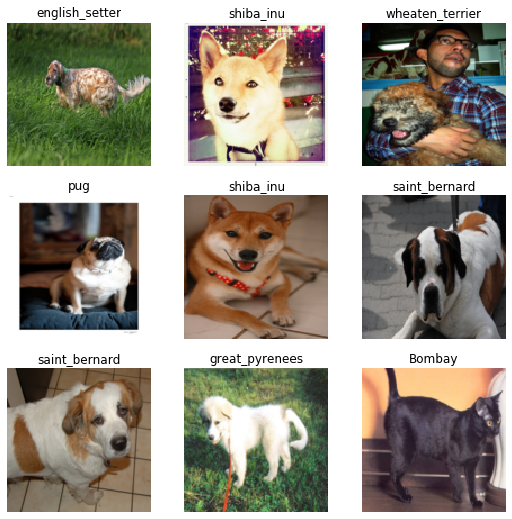

In [ ]:
_,axs = plt.subplots(3,3, figsize=(9,9))
trn_dl.show_batch(ctxs=axs.flatten())

## Create Databunch from DataSource


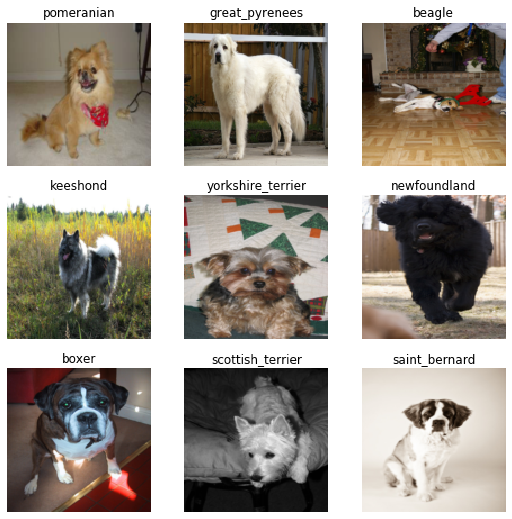

In [ ]:
dbch = pets.databunch(bs=9, after_item=item_img_tfms, after_batch=batch_tfms)
dbch.train_dl.show_batch()

In [ ]:
type(dbch.train_ds),type(dbch.valid_ds)

(fastai2.data.core.DataSource, fastai2.data.core.DataSource)

In [ ]:
len(dbch.train_ds), len(dbch.valid_ds)

(5912, 1478)

In [ ]:
type(dbch.train_dl),type(dbch.valid_dl)

(fastai2.data.core.TfmdDL, fastai2.data.core.TfmdDL)

## Add test dataloader to databunch

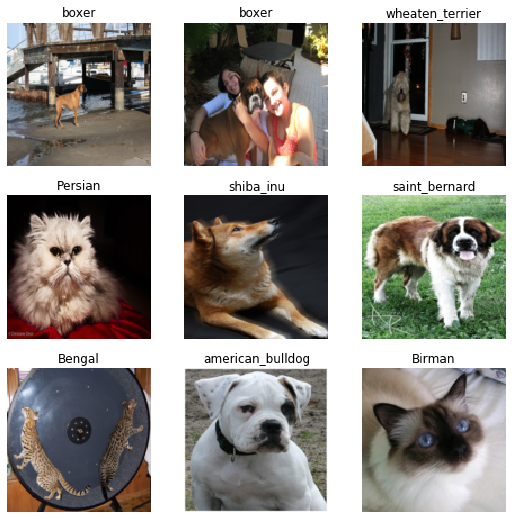

In [ ]:
dbch = pets.databunch(bs=9, after_item=item_img_tfms, after_batch=batch_tfms)
dbch.train_dl.show_batch()

In [ ]:
path = untar_data(URLs.PETS)
tst_files = get_image_files(path/"images")

In [ ]:
len(tst_files)

7390

In [ ]:
tst_files[0]

PosixPath('/home/quantran/.fastai/data/oxford-iiit-pet/images/chihuahua_57.jpg')

We can create a dataloader that takes those files and applies the **same transforms as the validation set** with test_dl.

In [ ]:
tst_dl = test_dl(dbch, tst_files)

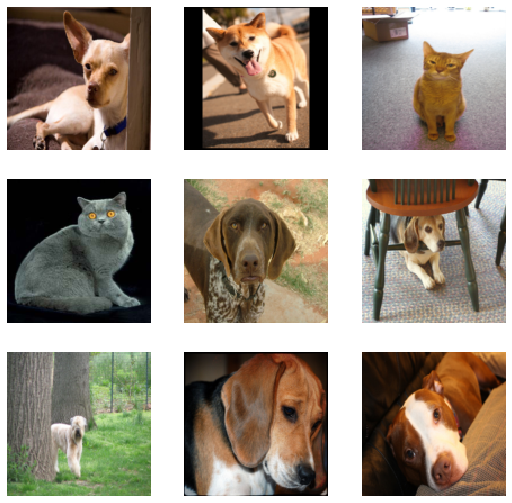

In [ ]:
tst_dl.show_batch(max_n=9)

## Segmentation

In [ ]:
class ImageResizer(Transform):
    order=10
    "Resize image to `size` using `resample"
    def __init__(self, size, resample=Image.BILINEAR):
        if not is_listy(size): size=(size,size)
        self.size,self.resample = (size[1],size[0]),resample
    
    #like I said above, multiple encodes in 1 transform
    def encodes(self, o:PILImage): return o.resize(size=self.size, resample=self.resample)
    def encodes(self, o:PILMask):  return o.resize(size=self.size, resample=Image.NEAREST)

By using the same transforms in `after_item` and `after_batch` but a different kind of targets (here segmentation masks), the targets are automatically processed as they should with the type-dispatch system.

In [ ]:
cv_source = untar_data(URLs.CAMVID_TINY)
cv_items = get_image_files(cv_source/'images')
cv_splitter = RandomSplitter(seed=42)
cv_split = cv_splitter(cv_items) 
cv_label = lambda o: cv_source/'labels'/f'{o.stem}_P{o.suffix}'

In [ ]:
cv_items

(#100) [/home/quantran/.fastai/data/camvid_tiny/images/0016E5_08101.png,/home/quantran/.fastai/data/camvid_tiny/images/Seq05VD_f03150.png,/home/quantran/.fastai/data/camvid_tiny/images/0006R0_f02910.png,/home/quantran/.fastai/data/camvid_tiny/images/Seq05VD_f02070.png,/home/quantran/.fastai/data/camvid_tiny/images/0006R0_f03630.png,/home/quantran/.fastai/data/camvid_tiny/images/0016E5_08280.png,/home/quantran/.fastai/data/camvid_tiny/images/0016E5_05730.png,/home/quantran/.fastai/data/camvid_tiny/images/0006R0_f03210.png,/home/quantran/.fastai/data/camvid_tiny/images/0001TP_008070.png,/home/quantran/.fastai/data/camvid_tiny/images/0016E5_08001.png...]

In [ ]:
len(cv_split[0]),len(cv_split[1])

(80, 20)

In [ ]:
print(cv_items[0])
#label: path to the img mask?
print(cv_label(cv_items[0]))

/home/quantran/.fastai/data/camvid_tiny/images/0016E5_08101.png
/home/quantran/.fastai/data/camvid_tiny/labels/0016E5_08101_P.png


Compare to previous task

```
tfms = [[PILImage.create], [labeller, Categorize()]]
pets = DataSource(items, tfms, filts=split_idx)

ds_img_tfms = [ImageResizer(128), ToTensor()]
dl_tfms = [Cuda(), ByteToFloatTensor()]

trn_dl = TfmdDL(pets.train, bs=9, after_item=ds_img_tfms, after_batch=dl_tfms)
```


In [ ]:
ds_img_tfms = [ImageResizer(128), ToTensor()]
dl_tfms = [Cuda(), IntToFloatTensor()]

In [ ]:
tfms = [[PILImage.create], [cv_label, PILMask.create]] # additional labeller: PILMask

camvid = DataSource(cv_items, tfms, splits=cv_split)
trn_dl = TfmdDL(camvid.train,  bs=4, after_item=ds_img_tfms, after_batch=dl_tfms)

PILMask: a very simple class, in order for transforms (ImageResizer, or ByteToFloatTensor) to apply the right encodes function based on type annotation

```
class PILMask(PILBase): _open_args,_show_args = {'mode':'L'},{'alpha':0.5, 'cmap':'tab20'}
```

In [ ]:
one_batch = trn_dl.one_batch()

In [ ]:
one_batch[0].shape,one_batch[1].shape # one batch (of 4)

(torch.Size([4, 3, 128, 128]), torch.Size([4, 128, 128]))

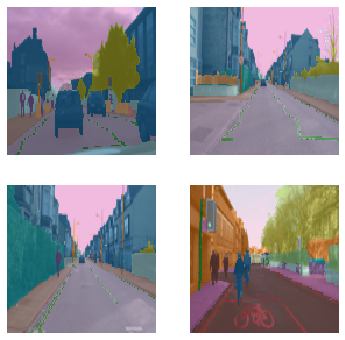

In [ ]:
_,axs = plt.subplots(2,2, figsize=(6,6))
trn_dl.show_batch(ctxs=axs.flatten())

## fin -

# Check GPU/CPU/IO bottlenekcs

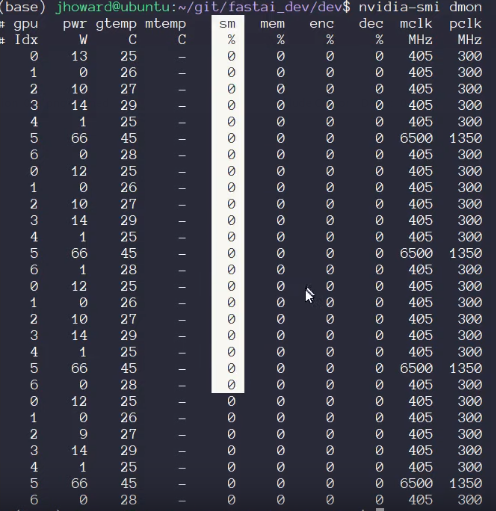

Check sm column: during heavy training, this should be ~90 to 100. Otherwise, CPU is doing the heavly lifting instead

When CPU is overly used, use Python profilers to find out what process is responsible. 

Use %prun. It uses a profiler which tells you which part of your code runs the longest, e.g.:
```
m = SomeModel(**kwargs)
%prun m.fit(X,y)
```

# Type dispatch

In [ ]:
??TypeDispatch

In [ ]:
class A(int): pass
class B(int): pass

def mult(x:A): return x*2
def add(x:B): return x+2

In [ ]:
temp = TypeDispatch(mult,add)
# TypeDispatch only use functions with specific type annotation
temp(10),temp(A(10)),temp(B(10))

(10, 20, 12)

# ToTensor and example of encode with type annotation

In [ ]:
ToTensor()

ToTensor: False {'PILMask': 'encodes', 'PILImageBW': 'encodes', 'PILImage': 'encodes'} {}

In [ ]:
@ToTensor
def encodes(self,o:str): return o

In [ ]:
ToTensor()

ToTensor: False {'str': 'encodes', 'PILImageBW': 'encodes', 'PILImage': 'encodes', 'PILMask': 'encodes'} {}

In [ ]:
temp = ToTensor()
temp2 = temp("sup")

In [ ]:
temp2

'sup'

# Export notebook

Involving 2 script files: notebook_core.ipynb and notebook_export.ipynb

Look at official note: 08 Pets Tutorial and Export section: https://forums.fast.ai/t/fastai-v2-code-walk-thru-1/53940

you can even create documentation

(from https://medium.com/@dienhoa.t/fast-ai-literature-programming-2d0d4230dd81)

You can find here the repo that I try to convert in literate programming: https://github.com/dienhoa/dagmm/tree/master

First I copy the notebook_core and notebook_export from fastai. (modify a little bit and remove what is unnecessary for me)

Then based on the original repo of dagmm, I copy the script to the jupyter notebook, change import name (the code exported is in folder local), and put a ‘#export’ in the cell I want to export